In [1]:
import numpy as np

class MarketEnvironment:
    def __init__(self, N_P, N_Y, dim_action_a, dim_action_b, Delta):
        # basic dimensions and state space grid
        self.N_P = N_P
        self.N_Y = N_Y
        self.dim_X = 2*self.N_P-1
        self.dim_Y = 2*self.N_Y+1
        self.dim_action_a = dim_action_a
        self.dim_action_b = dim_action_b
        self.prices = np.array(list(range(self.N_P+1)))
        self.Delta = Delta

        self.tick = 1/3
        self.k1 = 2
        self.p0 = 0.4
        self.A = np.exp(1)*(1/self.Delta)*self.p0


        # Transition probability matrix
        self.Q_X_i_i1 = np.zeros((self.dim_X-1, self.dim_X))
        self.Q_X_i1_i = np.zeros((self.dim_X-1, self.dim_X))
        self.lambda_i_i1 = (1/self.Delta)*np.array([0.5,1/3])
        self.lambda_i1_i = (1/self.Delta)*np.array([1/3,0.5])
        self._init_transition_probs()

        # Initial data for state variables
        self.N_RL_iter = 10**5  # # total steps of Q-learning iteration
        self.reset()

    def _init_transition_probs(self):
        for i in range(self.dim_X-1):
            self.Q_X_i1_i[i,i] = self.lambda_i1_i[i]
            self.Q_X_i1_i[i,i+1] = -self.lambda_i1_i[i]
            self.Q_X_i_i1[i,i] = -self.lambda_i_i1[i]
            self.Q_X_i_i1[i,i+1] = self.lambda_i_i1[i]

        self.Q_X = np.zeros((self.dim_X, self.dim_X))
        self.Q_X[0:(self.dim_X-1), 0:self.dim_X] += self.Q_X_i_i1
        self.Q_X[1:self.dim_X, 0:self.dim_X] += self.Q_X_i1_i

        self.P_X = np.identity(self.dim_X) + self.Delta*self.Q_X

    def lambda_e(self, D):
        return np.exp(-self.k1*D)*self.A

    def reset(self, ):
        """Reset the environment to its initial state."""
        # self.X_data = np.zeros(self.N_RL_iter+1)
        # self.Y_data = np.zeros(self.N_RL_iter+1)


        self.X_data = self.dim_X//2
        self.Y_data = self.dim_Y//2

    def step(self, p_a, p_b, x, y, idx_x):
        if x == 1:
            x_i1 = x + np.dot( np.random.multinomial(1, [ self.P_X[idx_x,idx_x],self.P_X[idx_x,idx_x+1] ]),
                            np.array([0,1]) )
        elif x == self.dim_X:
            x_i1 = x + np.dot( np.random.multinomial(1, [ self.P_X[idx_x,idx_x-1],self.P_X[idx_x,idx_x] ]),
                            np.array([-1,0]) )
        else:
            x_i1 = x + np.dot( np.random.multinomial(1, [ self.P_X[idx_x,idx_x-1],self.P_X[idx_x,idx_x],self.P_X[idx_x,idx_x+1] ]),
                            np.array([-1,0,1]) )

        # y inventory variable update: Bernouli RV to simulate if the ask or buy order is executed or not:
        p_ask_fill = self.lambda_e( -x*self.tick/2+p_a*self.tick )*self.Delta
        p_buy_fill = self.lambda_e( x*self.tick/2-p_b*self.tick )*self.Delta

        dna = 1 if np.random.uniform() <= p_ask_fill else 0
        dnb = 1 if np.random.uniform() <= p_buy_fill else 0

        if y == -self.N_Y:
            dna = 0
        if y == self.N_Y:
            dnb = 0

        y_i1 = y - dna + dnb
        # translate back from x,y values to x,y index
        idx_x_i1 = int(x_i1 - 1)
        idx_y_i1 = int(y_i1 + self.N_Y)
        if y_i1 == -self.N_Y: # then sell order is not allowed
            action_a_list = [self.dim_action_a-1] # do nothing for ask order
            action_b_list = self.prices[self.prices<x_i1/2] # the action is exactly equal to the index

        elif y_i1 == self.N_Y: # then buy order is not allowed
            action_a_list = self.prices[self.prices>x_i1/2]
            action_b_list = [self.dim_action_b-1] # do nothing for buy order

        else: # then both sell and buy orders are allowed
            action_a_list = self.prices[self.prices>x_i1/2] # the action is exactly equal to the index
            action_b_list = self.prices[self.prices<x_i1/2] # the action is exactly equal to the index

        # update the data of state variable
        self.X_data = idx_x_i1 # all are integers, i.e., 0,1,2,...,dim_X-1
        self.Y_data = idx_y_i1 # all are integers, i.e., 0,1,2,...,dim_Y-1


        reward = ( -x*self.tick/2+p_a*self.tick )*dna + ( x*self.tick/2-p_b*self.tick )*dnb # - (y**2)*Delta + (x_i1-x)*y

        return reward, idx_x_i1, idx_y_i1, action_a_list, action_b_list


# Example Usage:
# market_env = MarketEnvironment()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
#from market import MarketEnvironment

class QLearningAgent:

    def __init__(self, dim_X, dim_Y, dim_action_a, dim_action_b, Delta, N_RL_iter=10**5, N_learning_steps=3*10**4):
        self.dim_X = dim_X
        self.dim_Y = dim_Y
        self.dim_action_a = dim_action_a
        self.dim_action_b = dim_action_b
        self.N_RL_iter = N_RL_iter
        self.N_learning_steps = N_learning_steps
        self.Delta = Delta
        self.GAMMA = 0.95
        self.GAMMA_Delta = np.exp(-self.GAMMA*self.Delta)

        # Initialize Q-table and other matrices (for vanilla Q-learning with eps-greedy exploration)
        self.Q_table = np.zeros((dim_X, dim_Y, dim_action_a, dim_action_b))
        self.Q_table_track = np.zeros((dim_X, dim_Y, dim_action_a, dim_action_b, N_RL_iter))
        self.state_counter_matrix = np.zeros((dim_X, dim_Y))
        self.state_action_counter_matrix = np.zeros((dim_X, dim_Y, dim_action_a, dim_action_b))

        # Initialize an additional Q_hat-table for Q-learning with UCB exploration
        self.Q_upper_bound = 4
        self.Q_hat_table = np.zeros( (dim_X, dim_Y, dim_action_a, dim_action_b) ) + self.Q_upper_bound
        self.Q_hat_table_track = np.zeros( (dim_X, dim_Y, dim_action_a, dim_action_b, N_RL_iter) ) + self.Q_upper_bound

        # Define learning rate (for vanilla Q-learning with eps-greedy exploration)
        eps = 0.8
        eps0 = 0.95
        epoch = 2
        learning_rate = [eps*((eps0)**(i//epoch)) for i in range(N_learning_steps)]
        self.learning_rate_matrix = np.zeros((dim_X, dim_Y, dim_action_a, dim_action_b, N_learning_steps))
        for idx_x in range(dim_X):
            for idx_y in range(dim_Y):
                for p_a in range(dim_action_a):
                    for p_b in range(dim_action_b):
                        self.learning_rate_matrix[idx_x, idx_y, p_a, p_b, :] = np.array(learning_rate)

        # Define exploration probability (for vanilla Q-learning with eps-greedy exploration)
        eps = 1.0
        eps0 = 0.8
        epoch = 100
        EPSILON_list = [eps*((eps0)**(i//epoch)) for i in range(N_learning_steps)]
        self.explore_prob_matrix = np.zeros((dim_X, dim_Y, N_learning_steps))
        for idx_x in range(dim_X):
            for idx_y in range(dim_Y):
                self.explore_prob_matrix[idx_x, idx_y, :] = np.array(EPSILON_list)

        # Define learning rate (for Q-learning with UCB exploration)
        H = 5
        learning_rate_UCB = [(H+1)/(H+i) for i in range(N_learning_steps)]
        self.learning_rate_UCB_matrix = np.zeros((dim_X, dim_Y, dim_action_a, dim_action_b, N_learning_steps))
        for idx_x in range(dim_X):
            for idx_y in range(dim_Y):
                for p_a in range(dim_action_a):
                    for p_b in range(dim_action_b):
                        self.learning_rate_UCB_matrix[idx_x, idx_y, p_a, p_b, :] = np.array(learning_rate_UCB)

        # Define bonus rate (for Q-learning with UCB exploration)
        bonus_coef_1 = 0.01
        bonus_coef_0 = 0.01
        bonus_list = [np.sqrt( (bonus_coef_1 * np.log((i+1)*(i+2)) + bonus_coef_0 )/(i+1) ) for i in range(N_learning_steps)]
        self.bonus_matrix = np.zeros((dim_X, dim_Y, dim_action_a, dim_action_b, N_learning_steps))
        for idx_x in range(dim_X):
            for idx_y in range(dim_Y):
                for p_a in range(dim_action_a):
                    for p_b in range(dim_action_b):
                        self.bonus_matrix[idx_x, idx_y, p_a, p_b, :] = np.array(bonus_list)

    def plot_learning_parameters(self, method = 'eps-greedy'):
        if method == 'eps-greedy':
            # Plot learning rate
            plt.figure(1, figsize=(16, 5))
            plt.plot(self.learning_rate_matrix[0, 0, 0, 0, :], label='learning rate')
            plt.xlabel('step')
            plt.ylabel('Learning Rate')
            plt.show()

            # Plot exploration probability
            plt.figure(2, figsize=(16, 5))
            plt.plot(self.explore_prob_matrix[0, 0, :], label='exploration probability')
            plt.xlabel('step')
            plt.ylabel('Probability for Exploration')
            plt.show()
        elif method == 'UCB':
            # Plot learning rate
            plt.figure(1, figsize=(16, 5))
            plt.plot(self.learning_rate_UCB_matrix[0, 0, 0, 0, :], label='learning rate')
            plt.xlabel('step')
            plt.ylabel('Learning Rate')
            plt.show()

            # Plot bonus
            plt.figure(2, figsize=(16, 5))
            plt.plot(self.bonus_matrix[0, 0, 0, 0, :], label='bonus')
            plt.xlabel('step')
            plt.ylabel('Bonus')
            plt.show()

    def update(self, env, method = 'eps-greedy'):
        if method == 'UCB':
            self.Q_table = np.zeros( (dim_X, dim_Y, dim_action_a, dim_action_b) ) + self.Q_upper_bound

        for i in range(self.N_RL_iter):
            if i % (10**4) == 0:
                print(f"Iteration: {i}")
            # the transition from i to i+1
            self.Q_table_track[:,:,:,:,i] = self.Q_table[:,:,:,:]
            self.Q_hat_table_track[:,:,:,:,i] = self.Q_hat_table[:,:,:,:]
            # main part of the Q-learning algorithm

            # Part 1: choose the action to do given the state at i-th time point
            p_a = 0 # quoted ask price
            p_b = 0 # quoted bid price
            #########
            # Make a list of the actions available from the current state
            idx_x = int(env.X_data) # all are integers, i.e., 0,1,2,...,dim_X-1
            idx_y = int(env.Y_data) # all are integers, i.e., 0,1,2,...,dim_Y-1

            count_xy = int(self.state_counter_matrix[idx_x,idx_y])
            self.state_counter_matrix[idx_x,idx_y] = count_xy+1

            EPSILON = self.explore_prob_matrix[ idx_x, idx_y, count_xy ]  #exploration probability for this state

            x = idx_x + 1 # midprice=x*tick_size/2 and x is in (1,2,...,dim_X)
            y = idx_y - env.N_Y # y = the true signed integer value of inventory

            if y == -env.N_Y: # then sell order is not allowed
                action_a_list = [dim_action_a-1] # do nothing for ask order
                action_b_list = env.prices[env.prices<x/2] # the action is exactly equal to the index
                # x/2 is because the middle price is on grid: 0, 1/2, 1, 3/2, 2, ...,
                # but the quoted price is on grid: 0,1,2,...
                p_a = dim_action_a-1

                if np.random.binomial(1, EPSILON) == 1 and method == 'eps-greedy':
                    p_b = np.random.choice(action_b_list)
                else:
                    Q_values_xy = self.Q_table[idx_x, idx_y, :, :][np.ix_( list(action_a_list), list(action_b_list) )]
                    idx_max_a, idx_max_b = np.where(Q_values_xy == Q_values_xy.max())
                    p_b = action_b_list[ idx_max_b[0] ]

            elif y == env.N_Y: # then buy order is not allowed
                action_a_list = env.prices[env.prices>x/2]
                action_b_list = [dim_action_b-1] # do nothing for buy order
                p_b = dim_action_b-1

                if np.random.binomial(1, EPSILON) == 1 and method == 'eps-greedy':
                    p_a = np.random.choice(action_a_list)
                else:
                    Q_values_xy = self.Q_table[idx_x, idx_y, :, :][np.ix_( list(action_a_list), list(action_b_list) )]
                    idx_max_a, idx_max_b = np.where(Q_values_xy == Q_values_xy.max())
                    p_a = action_a_list[ idx_max_a[0] ]


            else: # then both sell and buy orders are allowed
                action_a_list = env.prices[env.prices>x/2] # the action is exactly equal to the index
                action_b_list = env.prices[env.prices<x/2] # the action is exactly equal to the index
                if np.random.binomial(1, EPSILON) == 1 and method == 'eps-greedy':
                    p_a = np.random.choice(action_a_list)
                    p_b = np.random.choice(action_b_list)
                else:
                    Q_values_xy = self.Q_table[idx_x, idx_y, :, :][np.ix_( list(action_a_list), list(action_b_list) )]
                    idx_max_a, idx_max_b = np.where(Q_values_xy == Q_values_xy.max())
                    p_a = action_a_list[ idx_max_a[0] ] # Wrong(do not do this!!! the index list is different!!): indeed, we can directly use idx_max_b[0], because the action is exactly equal to the index
                    p_b = action_b_list[ idx_max_b[0] ]

            # the above will output p_a p_b, this action is together with the state at time i

            # then we update our counter for (state, action) pair
            count_s_a = int(self.state_action_counter_matrix[idx_x, idx_y, p_a, p_b])
            self.state_action_counter_matrix[idx_x, idx_y, p_a, p_b] = count_s_a+1


            # observe the reward and the next state

            reward, idx_x_i1, idx_y_i1, action_a_list, action_b_list = env.step(p_a, p_b, x, y, idx_x)

            Q_values_xy = self.Q_table[idx_x_i1, idx_y_i1, :, :][np.ix_( action_a_list, action_b_list )]

            Q_value_max_new_i1 = Q_values_xy.max()

            # Update Q-table
            if method == 'eps-greedy':

                Q_value_new = reward + self.GAMMA_Delta * Q_value_max_new_i1
                Q_value_old = self.Q_table[idx_x, idx_y, p_a, p_b]

                self.Q_table[idx_x, idx_y, p_a, p_b] = self.learning_rate_matrix[idx_x, idx_y, p_a, p_b, count_s_a] * (Q_value_new-Q_value_old) + Q_value_old

            elif method == 'UCB':

                Q_value_new = reward + self.GAMMA_Delta * Q_value_max_new_i1 + self.bonus_matrix[idx_x, idx_y, p_a, p_b, count_s_a]
                Q_value_old = self.Q_hat_table[idx_x, idx_y, p_a, p_b]

                self.Q_hat_table[idx_x, idx_y, p_a, p_b] = self.learning_rate_UCB_matrix[idx_x, idx_y, p_a, p_b, count_s_a] * (Q_value_new-Q_value_old) + Q_value_old

                self.Q_table[idx_x, idx_y, p_a, p_b] = min(self.Q_table[idx_x, idx_y, p_a, p_b], self.Q_hat_table[idx_x, idx_y, p_a, p_b])

        self.plot_result(method)

    def plot_result(self, method = 'eps-greedy'):
        plt.figure(1, figsize=(20, 8))
        M=self.N_RL_iter
        plt.plot(self.Q_table_track[0,2,1,3,:M], label='a=1')
        plt.plot(self.Q_table_track[0,2,2,3,:M], label='a=2')
        plt.plot(self.Q_table_track[0,2,0,3,:M])
        plt.plot(self.Q_table_track[0,2,3,3,:M])
        plt.xlabel('step')
        plt.ylabel('Q(s,a)')
        plt.show()

        if method == 'UCB':
            plt.figure(2, figsize=(20, 8))
            M=self.N_RL_iter
            plt.plot(self.Q_hat_table_track[0,2,1,3,:M], label='a=1')
            plt.plot(self.Q_hat_table_track[0,2,2,3,:M], label='a=2')
            plt.plot(self.Q_hat_table_track[0,2,0,3,:M])
            plt.plot(self.Q_hat_table_track[0,2,3,3,:M])
            plt.xlabel('step')
            plt.ylabel('Q_hat(s,a)')
            plt.show()

    def results_check(self, ):
        print('---------- the visiting number for each state: ----------')
        print(self.state_counter_matrix)
        action_a_RL = np.zeros( (dim_X, dim_Y) )
        action_b_RL = np.zeros( (dim_X, dim_Y) )
        V_RL = np.zeros( (dim_X, dim_Y) )
        print('---------- the Q function for each state: ----------')
        for idx_x in range(dim_X):
            for idx_y in range(dim_Y):
                x = int(idx_x + 1)
                y = int(idx_y - env.N_Y)
                if y == -env.N_Y: # then sell order is not allowed
                    action_a_list = [dim_action_a-1] # do nothing for ask order
                    action_b_list = env.prices[env.prices<x/2] # the action is exactly equal to the index
                    print( f'(x,y)={x},{y}' )
                    print(action_a_list)
                    print(action_b_list)
                    #print( state_action_counter_matrix[ idx_x, idx_y, action_a_list, action_b_list] )
                    print( self.state_action_counter_matrix[ idx_x, idx_y, :, :] )
                    print( self.Q_table[ idx_x, idx_y, :, :] )

                    Q_values_xy = self.Q_table[idx_x, idx_y, :, :][np.ix_( action_a_list, action_b_list )]
                    idx_max_a, idx_max_b = np.where(Q_values_xy == Q_values_xy.max())
                    p_a = dim_action_a-1
                    p_b = action_b_list[ idx_max_b[0] ]

                elif y == env.N_Y: # then buy order is not allowed
                    action_a_list = env.prices[env.prices>x/2]
                    action_b_list = [dim_action_b-1] # do nothing for buy order
                    print( f'(x,y)={x},{y}' )
                    print(action_a_list)
                    print(action_b_list)
                    #print( state_action_counter_matrix[ idx_x, idx_y, action_a_list, action_b_list] )
                    print( self.state_action_counter_matrix[ idx_x, idx_y, :, :] )
                    print( self.Q_table[ idx_x, idx_y, :, :] )

                    Q_values_xy = self.Q_table[idx_x, idx_y, :, :][np.ix_( action_a_list, action_b_list )]
                    idx_max_a, idx_max_b = np.where(Q_values_xy == Q_values_xy.max())
                    p_a = action_a_list[ idx_max_a[0] ]
                    p_b = dim_action_b-1

                else: # then both sell and buy orders are allowed
                    action_a_list = env.prices[env.prices>x/2] # the action is exactly equal to the index
                    action_b_list = env.prices[env.prices<x/2] # the action is exactly equal to the index
                    print( f'(x,y)={x},{y}' )
                    print(action_a_list)
                    print(action_b_list)
                    #print( state_action_counter_matrix[ idx_x, idx_y, action_a_list, action_b_list] )
                    print( self.state_action_counter_matrix[ idx_x, idx_y, :, :] )
                    print( self.Q_table[ idx_x, idx_y, :, :] )

                    Q_values_xy = self.Q_table[idx_x, idx_y, :, :][np.ix_( action_a_list, action_b_list )]
                    idx_max_a, idx_max_b = np.where(Q_values_xy == Q_values_xy.max())
                    p_a = action_a_list[ idx_max_a[0] ]
                    p_b = action_b_list[ idx_max_b[0] ]

                V_RL[idx_x, idx_y] = Q_values_xy.max()
                action_a_RL[idx_x, idx_y] = p_a
                action_b_RL[idx_x, idx_y] = p_b
        print('---------- the learned value function and policy: ----------')
        print(V_RL)
        print(action_a_RL)
        print(action_b_RL)

##UCB

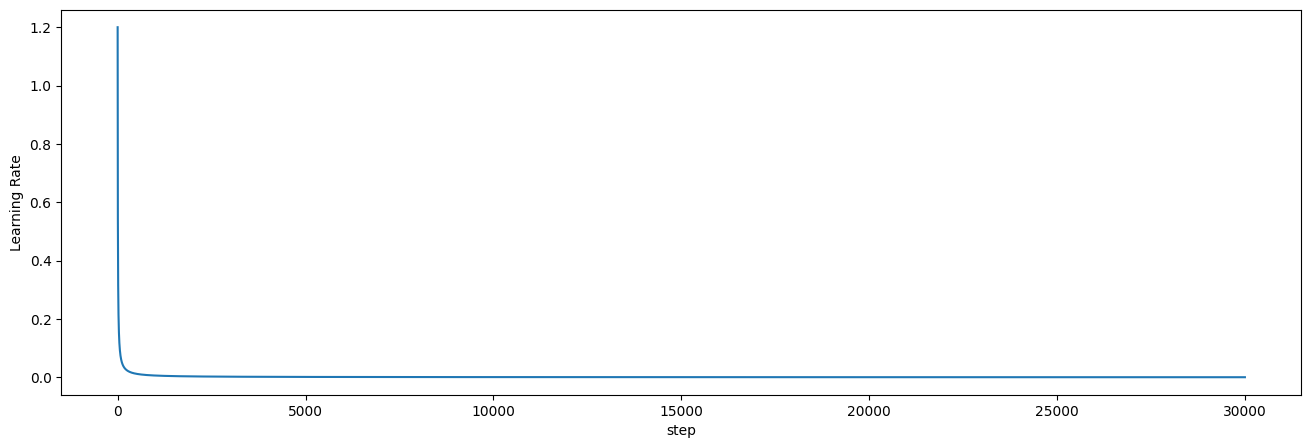

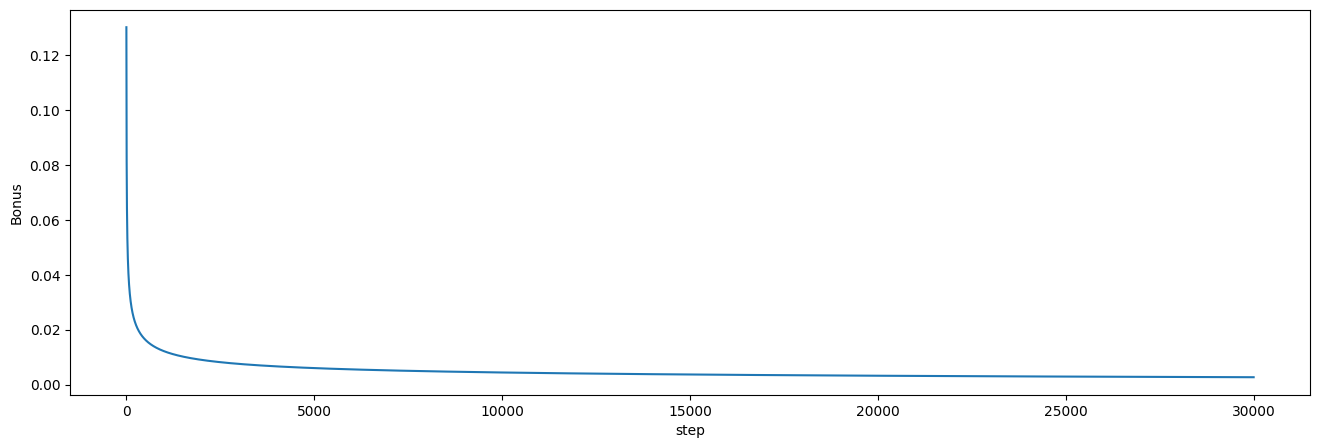

Iteration: 0
Iteration: 10000
Iteration: 20000
Iteration: 30000
Iteration: 40000
Iteration: 50000
Iteration: 60000
Iteration: 70000
Iteration: 80000
Iteration: 90000


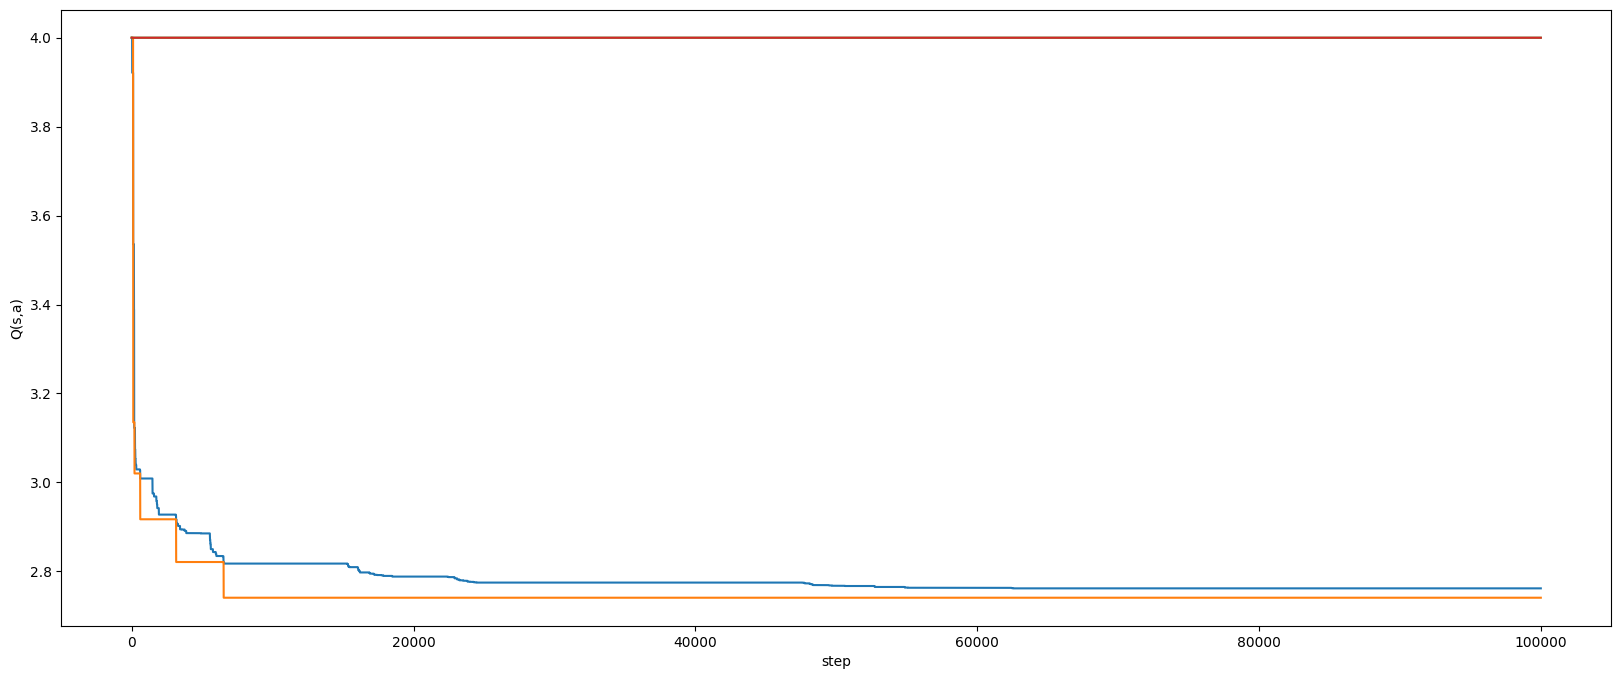

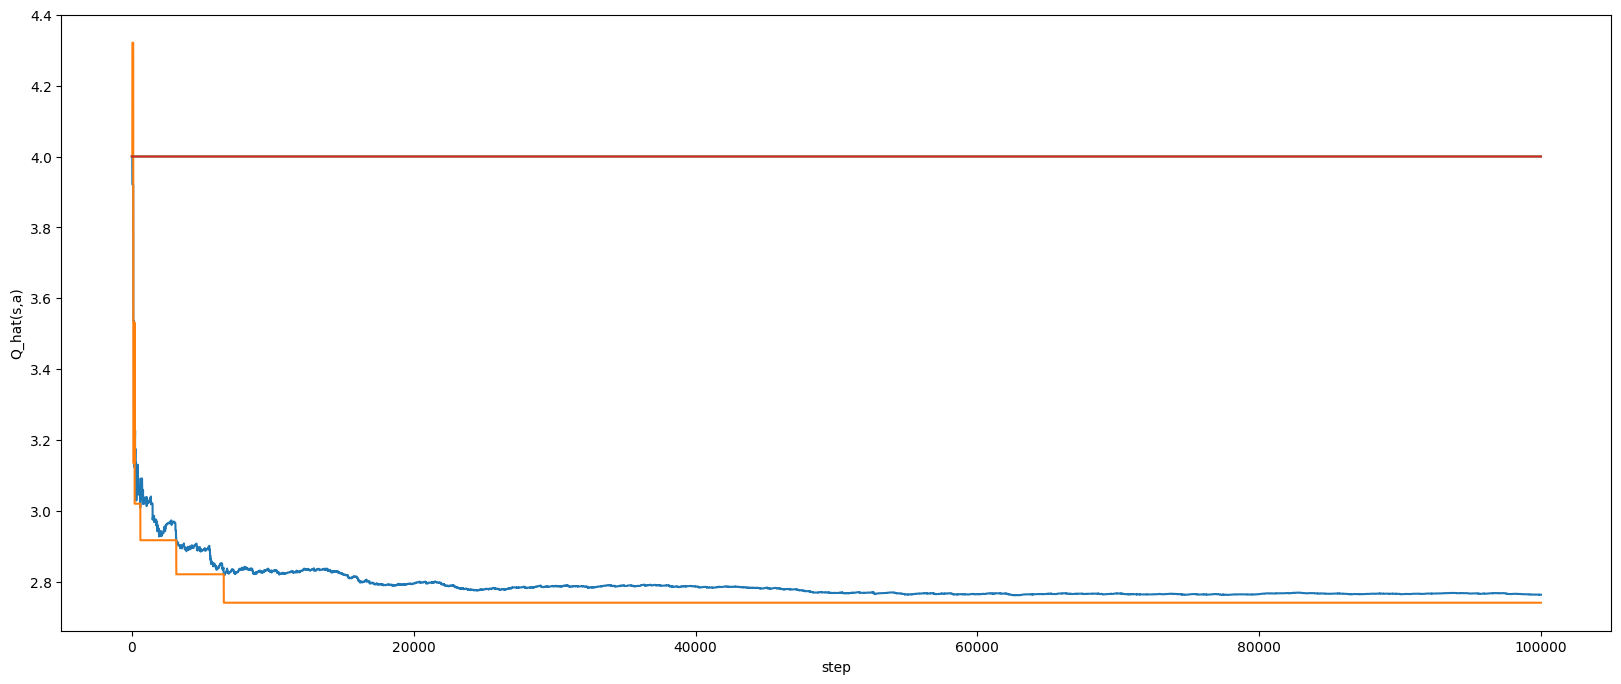

In [15]:
# Example usage
N_P = 2 # price grid dimension - 1 (because we start from 0)
N_Y = 1 # (inventory grid dimension - 1)/2 (because we allow both - and + and 0)
Delta = 0.1

dim_X = 2*N_P-1
dim_Y = 2*N_Y+1
dim_action_a = N_P+2
dim_action_b = N_P+2

agent = QLearningAgent(dim_X, dim_Y, dim_action_a, dim_action_b, Delta)
agent.plot_learning_parameters(method = 'UCB')

env = MarketEnvironment(N_P, N_Y, dim_action_a, dim_action_b, Delta)
env.reset()

np.random.seed(999)

agent.update(env, method = 'UCB')

In [16]:
agent.results_check()

---------- the visiting number for each state: ----------
[[ 5802. 17469.  5221.]
 [10376. 25916.  6566.]
 [ 8357. 16007.  4286.]]
---------- the Q function for each state: ----------
(x,y)=1,-1
[3]
[0]
[[   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [5802.    0.    0.    0.]]
[[4.         4.         4.         4.        ]
 [4.         4.         4.         4.        ]
 [4.         4.         4.         4.        ]
 [2.76100305 4.         4.         4.        ]]
(x,y)=1,0
[1 2]
[0]
[[    0.     0.     0.     0.]
 [17408.     0.     0.     0.]
 [   61.     0.     0.     0.]
 [    0.     0.     0.     0.]]
[[4.         4.         4.         4.        ]
 [2.86778377 4.         4.         4.        ]
 [2.86052202 4.         4.         4.        ]
 [4.         4.         4.         4.        ]]
(x,y)=1,1
[1 2]
[3]
[[   0.    0.    0.    0.]
 [   0.    0.    0. 5212.]
 [   0.    0.    0.    9.]
 [   0.    0.    0.    0.]]
[[4.         4.         4.         4

## eps-greedy

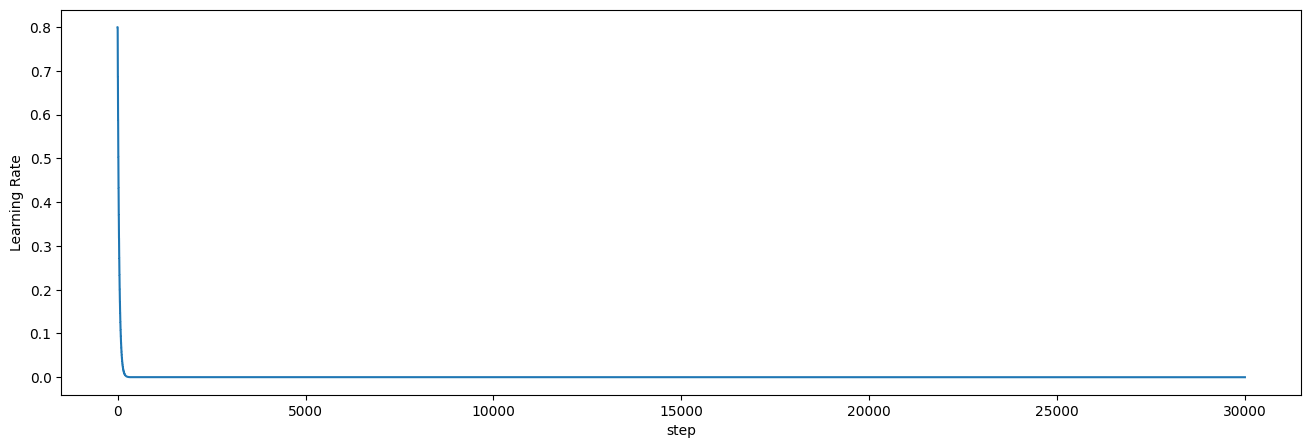

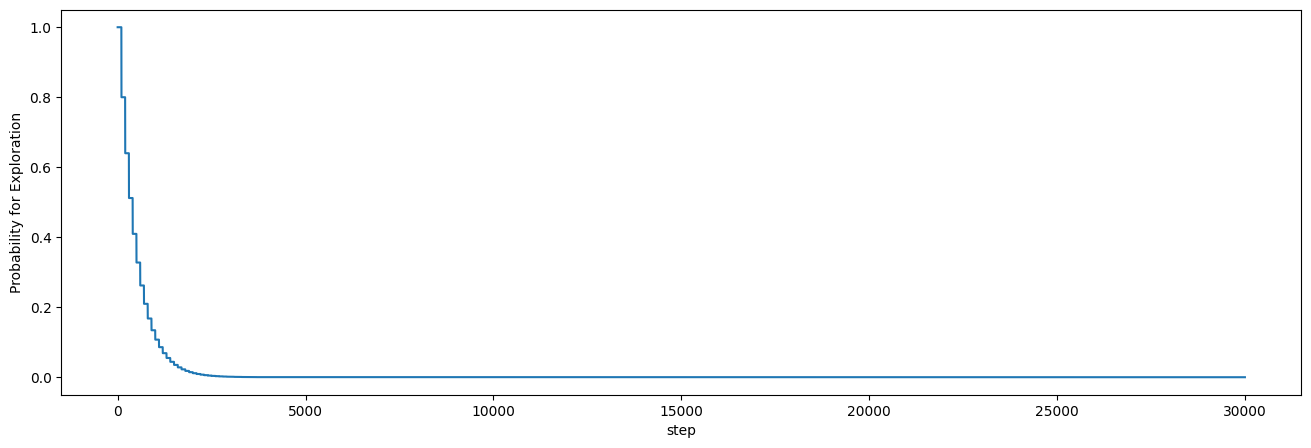

Iteration: 0
Iteration: 10000
Iteration: 20000
Iteration: 30000
Iteration: 40000
Iteration: 50000
Iteration: 60000
Iteration: 70000
Iteration: 80000
Iteration: 90000


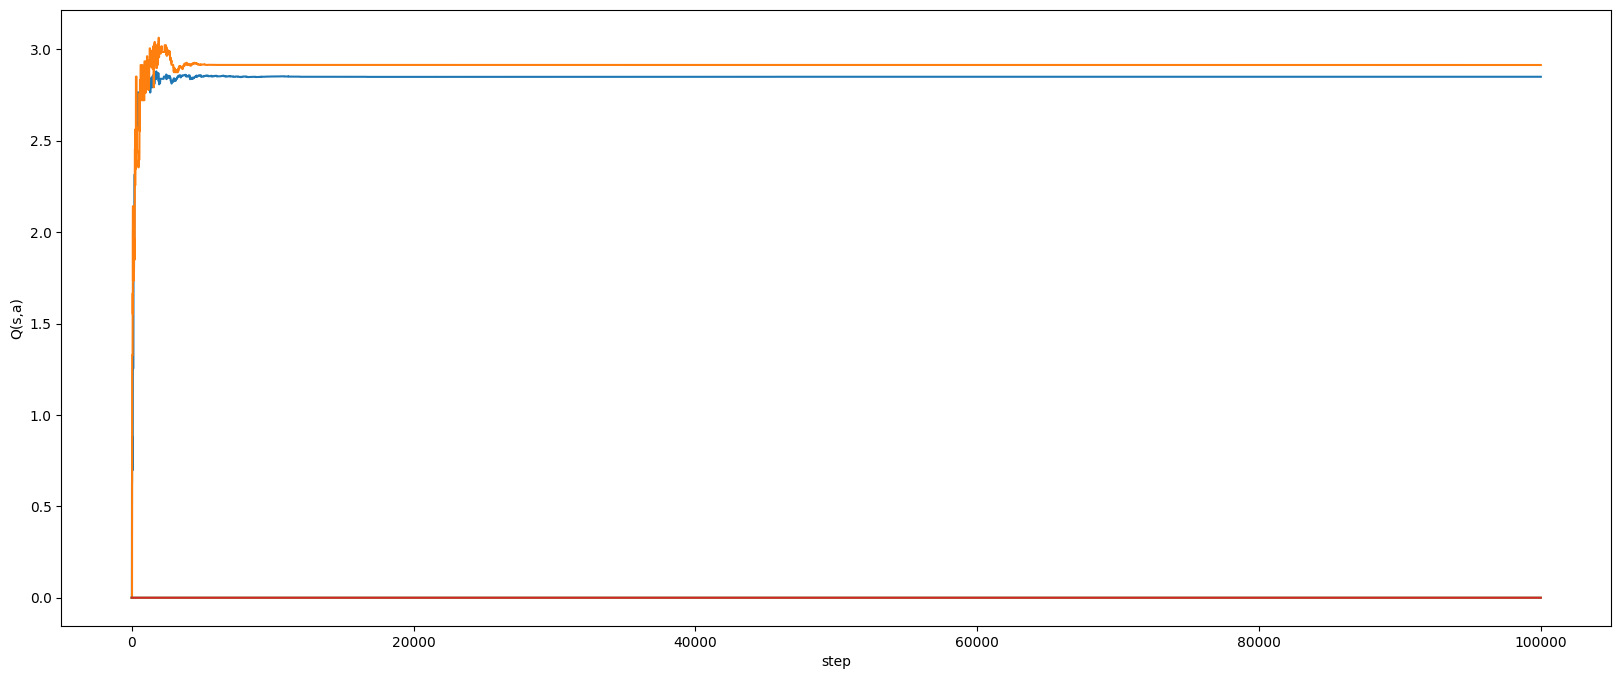

In [4]:
# Example usage
N_P = 2 # price grid dimension - 1 (because we start from 0)
N_Y = 1 # (inventory grid dimension - 1)/2 (because we allow both - and + and 0)
Delta = 0.1

dim_X = 2*N_P-1
dim_Y = 2*N_Y+1
dim_action_a = N_P+2
dim_action_b = N_P+2

agent = QLearningAgent(dim_X, dim_Y, dim_action_a, dim_action_b, Delta)
agent.plot_learning_parameters(method = 'eps-greedy')

env = MarketEnvironment(N_P, N_Y, dim_action_a, dim_action_b, Delta)
env.reset()

np.random.seed(999)

agent.update(env, method = 'eps-greedy')

In [5]:
agent.results_check()

---------- the visiting number for each state: ----------
[[ 4438. 14584.  9648.]
 [10437. 21631. 10777.]
 [ 9542. 14428.  4515.]]
---------- the Q function for each state: ----------
(x,y)=1,-1
[3]
[0]
[[   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]
 [4438.    0.    0.    0.]]
[[0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]
 [2.850482 0.       0.       0.      ]]
(x,y)=1,0
[1 2]
[0]
[[    0.     0.     0.     0.]
 [  294.     0.     0.     0.]
 [14290.     0.     0.     0.]
 [    0.     0.     0.     0.]]
[[0.         0.         0.         0.        ]
 [2.95941389 0.         0.         0.        ]
 [2.99008934 0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
(x,y)=1,1
[1 2]
[3]
[[   0.    0.    0.    0.]
 [   0.    0.    0.  246.]
 [   0.    0.    0. 9402.]
 [   0.    0.    0.    0.]]
[[0.         0.         0.         0.        ]
 [0.         0.      